# Logistic Regression

In [1]:
import optuna
from sklearn.linear_model import LogisticRegression
from utils.preprocessing import *
from utils.visualization import *
from utils.trainer import *
from utils.helpers import *
from utils.config import *

In [2]:
model_name       = 'lr'
best_params_path = paths[model_name]['best_params']
model_path_list  = paths[model_name]['models']
pred_5folds_path = paths[model_name]['pred_5folds']
shap_fi_path     = paths[model_name]['shap_fi']

## 1. Load data

In [3]:
# Get lists of data by folds
X_train_list = [pd.read_csv(path) for path in X_train_paths]
y_train_list = [pd.read_csv(path) for path in y_train_paths]
y_train_list = [y_train[TARGET].to_numpy() for y_train in y_train_list]

X_val_list   = [pd.read_csv(path) for path in X_val_paths]
y_val_list   = [pd.read_csv(path) for path in y_val_paths]
y_val_list   = [y_val[TARGET].to_numpy() for y_val in y_val_list]

## 2. Hyperparameters Tuning

In [4]:
def objective(trial):    
    param = {
        'C'           : trial.suggest_float('C', 1e-3, 100),
        'penalty'     : trial.suggest_categorical('penalty', ['l1', 'l2']),
        'max_iter'    : trial.suggest_int('max_iter', 10, 2000),
        'random_state': RANDOM_STATE,
        'solver'      : 'liblinear',
    }
    
    trainer = BaseTrainer(model=LogisticRegression(**param))
    mean_metrics, *_ = trainer.perform_cross_validation(
        X_train_list, y_train_list,
        X_val_list, y_val_list,
        verbose=0
    )
    avg = (mean_metrics.get('mean_accuracy') + mean_metrics.get('mean_f1_score') + mean_metrics.get('mean_roc_auc')) / 3
    return avg

In [6]:
HP_TUNING = False

if HP_TUNING:
    direction = 'maximize'
    n_trials  = 500
    n_jobs    = -1

    study = optuna.create_study(direction=direction)
    study.optimize(objective, n_trials=n_trials, n_jobs=n_jobs)

    best_params = study.best_trial.params
    best_params.update({
        'random_state': RANDOM_STATE,
        'solver'      : 'liblinear',
    })
else:
    best_params = load_json(best_params_path)
    
best_params

{'C': 26.073041770026837,
 'penalty': 'l1',
 'max_iter': 994,
 'random_state': 42,
 'solver': 'liblinear'}

## 3. Train with 5-fold cross validation

In [7]:
trainer = BaseTrainer(model=LogisticRegression(**best_params))
mean_metrics, y_pred_list, y_pred_proba_list, fi_list = trainer.perform_cross_validation(
    X_train_list=X_train_list,
    y_train_list=y_train_list,
    X_val_list=X_val_list,
    y_val_list=y_val_list,
    #model_path_list=model_path_list, # uncomment if you want to save newly trained models
    verbose=1,
)

Fold 1/5:
	- ACCURACY: 0.7636
	- ROC_AUC: 0.8640
	- F1_SCORE: 0.7347
	- MSE: 0.1651
	- PRECISION: 0.7500
	- RECALL: 0.7200
	- SPECIFICITY: 0.8000

Fold 2/5:
	- ACCURACY: 0.8727
	- ROC_AUC: 0.9307
	- F1_SCORE: 0.8571
	- MSE: 0.1062
	- PRECISION: 0.8750
	- RECALL: 0.8400
	- SPECIFICITY: 0.9000

Fold 3/5:
	- ACCURACY: 0.8182
	- ROC_AUC: 0.9027
	- F1_SCORE: 0.8000
	- MSE: 0.1203
	- PRECISION: 0.8000
	- RECALL: 0.8000
	- SPECIFICITY: 0.8333

Fold 4/5:
	- ACCURACY: 0.7963
	- ROC_AUC: 0.8607
	- F1_SCORE: 0.7660
	- MSE: 0.1523
	- PRECISION: 0.8182
	- RECALL: 0.7200
	- SPECIFICITY: 0.8621

Fold 5/5:
	- ACCURACY: 0.8148
	- ROC_AUC: 0.9048
	- F1_SCORE: 0.8077
	- MSE: 0.1291
	- PRECISION: 0.7778
	- RECALL: 0.8400
	- SPECIFICITY: 0.7931

------------------------------
	- MEAN_ACCURACY: 0.8131
	- MEAN_ROC_AUC: 0.8926
	- MEAN_F1_SCORE: 0.7931
	- MEAN_MSE: 0.1346
	- MEAN_PRECISION: 0.8042
	- MEAN_RECALL: 0.7840
	- MEAN_SPECIFICITY: 0.8377


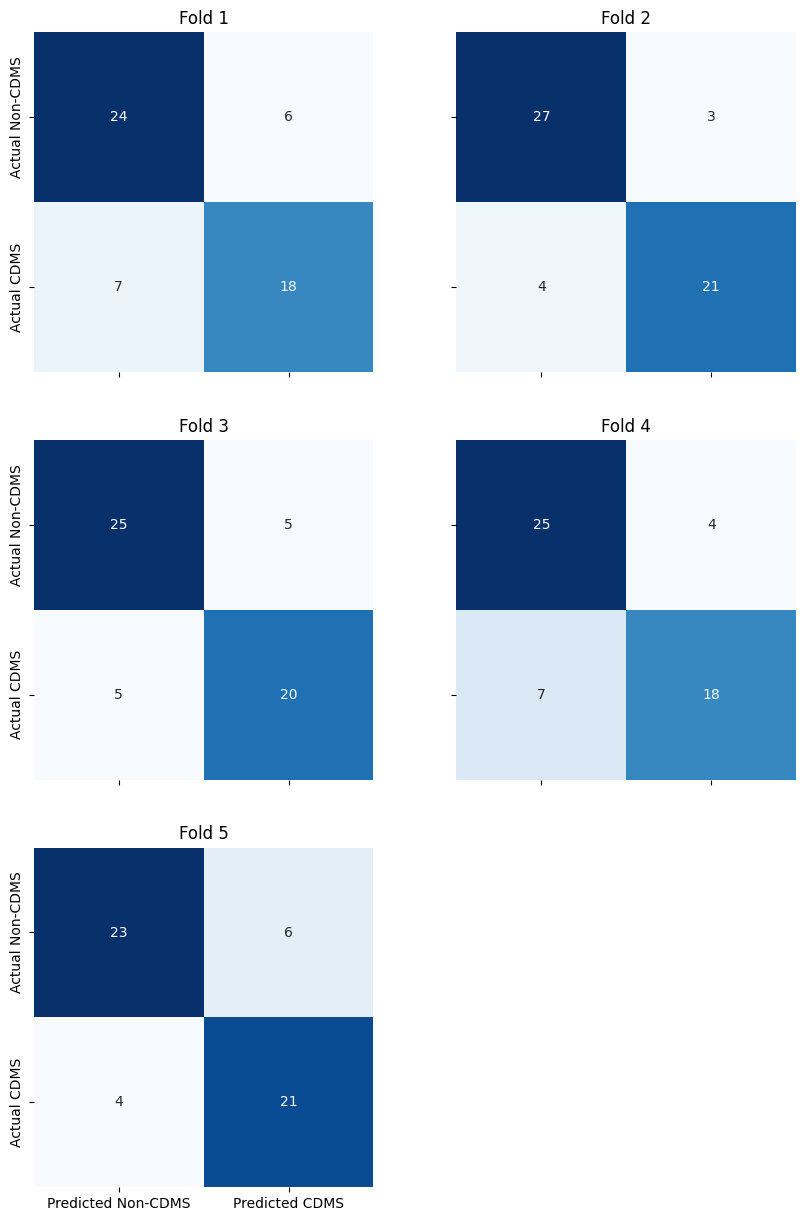

In [8]:
plot_confusion_matrix_folds(
    y_test_list=y_val_list,
    y_pred_list=y_pred_list,
)

## 4. Get predictions

In [9]:
analyzed_dfs = []

for fold in range(1, 6):
    # Load data for the current fold
    X_train, y_train, X_val, y_val = load_data_fold(fold)

    # Load trained model for the current fold
    model = load_model_fold(fold, model_name=model_name)

    # Get predictions
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:,-1]

    # Add ground truths and predictions to the current df
    analyzed_df = X_val.copy()
    analyzed_df['Actual'] = y_val
    analyzed_df['Predicted'] = y_pred
    analyzed_df['Predicted_Proba'] = y_pred_proba
    analyzed_dfs.append(analyzed_df)

analyzed_df_aggregated = pd.concat(analyzed_dfs, axis=0).reset_index(drop=True)
print(f'analyzed_df_aggregated.shape: {analyzed_df_aggregated.shape}')

# analyzed_df_aggregated.to_csv(pred_5folds_path, index=False)
# print(f'Save df to {pred_5folds_path}')

analyzed_df_aggregated.shape: (273, 23)


## 5. Explain with SHAP

In [10]:
import shap

models = [load_model_fold(fold+1, model_name) for fold in range(5)]
shap_values_folds = []

for fold in range(5):
    model = models[fold]
    X_train = X_train_list[fold]
    X_val = X_val_list[fold]

    explainer = shap.LinearExplainer(model, X_train)
    shap_values_fold = explainer.shap_values(X_val)
    mean_shap_values_fold = np.mean(np.abs(shap_values_fold), axis=0)
    shap_values_folds.append(mean_shap_values_fold)

# Aggregate SHAP values across folds
aggregated_shap_values = np.mean(shap_values_folds, axis=0)

# Calculate mean absolute SHAP values for feature importance
feature_names = X_val_list[0].columns.to_list()
shap_feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': aggregated_shap_values
})

# Sort by importance
#shap_feature_importance.sort_values(by='Importance', ascending=False, inplace=True)
shap_feature_importance.to_csv(shap_fi_path, index=False)
shap_feature_importance

,Feature,Importance
0,Gender,0.361187
1,Age,0.246210
2,Schooling,0.660561
3,Breastfeeding,0.311755
4,Varicella,0.232185
5,Oligoclonal_Bands,0.682161
6,LLSSEP,0.256296
7,ULSSEP,0.146973
8,VEP,0.302227
9,BAEP,0.183093
